In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
WORKSPACE='uqml'
RESOURCE_GROUP='uqml'
SUBSCRIPTION_ID='96185854-d711-439b-bfa4-fc8abfc8983c'

## create experiment

In [3]:
from azureml.core import Workspace, Experiment

ws = Workspace.get(
    name=WORKSPACE,
    subscription_id=SUBSCRIPTION_ID,
    resource_group=RESOURCE_GROUP,
)
exp = Experiment(workspace=ws, name="optimizing_ml_pipeline")

print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep = '\n')

run = exp.start_logging()

Workspace name: uqml
Azure region: uksouth
Subscription id: 96185854-d711-439b-bfa4-fc8abfc8983c
Resource group: uqml


## create a compute cluster

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "mlopscluster"

# Verify that cluster does not exist already
try:
    cpu_cluster = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4)
    cpu_cluster = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

cpu_cluster.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


## create conda environment file and register environment

In [5]:
%%writefile conda_dependencies.yml

dependencies:
- python=3.6.2
- scikit-learn
- pip:
  - azureml-defaults

Overwriting conda_dependencies.yml


In [6]:
from azureml.core import Environment
sklearn_env = Environment.from_conda_specification(name = 'sklearn-env', file_path = './conda_dependencies.yml')

# 1 - hyperdrive config

## setup hyperdrive config and submit

In [18]:
from azureml.widgets import RunDetails
from azureml.train.sklearn import SKLearn
from azureml.core import ScriptRunConfig
from azureml.train.hyperdrive.run import PrimaryMetricGoal
from azureml.train.hyperdrive.policy import BanditPolicy
from azureml.train.hyperdrive.sampling import RandomParameterSampling
from azureml.train.hyperdrive.runconfig import HyperDriveConfig
from azureml.train.hyperdrive.parameter_expressions import uniform, normal, choice, quniform
import os


# Specify parameter sampler
ps = RandomParameterSampling( {
    "C": uniform(0.0, 1.0),
    "max_iter": quniform(100, 2000, 1)
} )

# Specify a Policy
policy = BanditPolicy(slack_factor = 0.1, evaluation_interval=3, delay_evaluation=1)

if "training" not in os.listdir():
    os.mkdir("./training")

# Create a SKLearn estimator for use with train.py
src = ScriptRunConfig(source_directory='.',
                      script='train.py',
                      compute_target=ws.compute_targets['mlopscluster'],
                      environment=sklearn_env)

# Create a HyperDriveConfig using the estimator, hyperparameter sampler, and policy.
hyperdrive_config = HyperDriveConfig(run_config=src,
                             hyperparameter_sampling=ps,
                             policy=policy,
                             primary_metric_name="accuracy",
                             primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                             max_total_runs=20,
                             max_concurrent_runs=3)

hyperdrive_run = exp.submit(hyperdrive_config)

## inspect the results

In [19]:
import joblib
# Get your best run and save the model from that run.

best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
parameter_values = best_run.get_details()['runDefinition']['arguments']

print('Best Run Id: ', best_run.id)
print(best_run_metrics)

Best Run Id:  HD_895564f7-e21f-4f21-a977-d76284cc7b22_11
{'regularization_strength': 0.9292016190903832, 'max_iterations': 346, 'accuracy': 0.9090436139772826}


## save the model

In [22]:
type(best_run)

azureml.core.run.Run

In [21]:
model.save()

NameError: name 'model' is not defined

# 2 - automl

In [7]:
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from azureml.data.dataset_factory import TabularDatasetFactory
from train import clean_data

ds=TabularDatasetFactory.from_delimited_files("https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/bankmarketing_train.csv")

x, y = clean_data(ds)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.65,test_size=0.35, random_state=101)

In [9]:
from azureml.train.automl import AutoMLConfig
# Set parameters for AutoMLConfig
# NOTE: DO NOT CHANGE THE experiment_timeout_minutes PARAMETER OR YOUR INSTANCE WILL TIME OUT.
# If you wish to run the experiment longer, you will need to run this notebook in your own
# Azure tenant, which will incur personal costs.
automl_config = AutoMLConfig(
    experiment_timeout_minutes=15,
    task= 'classification',
    primary_metric='accuracy',
    training_data=x,
    label_column_name='y',
    n_cross_validations=2)

# Submit automl run
#experiment = Experiment(ws, "automl-experiment")
run = exp.submit(automl_config, show_output=True)



No run_configuration provided, running on local with default configuration
Running in the active local environment.


Experiment,Id,Type,Status,Details Page,Docs Page
optimizing_ml_pipeline,AutoML_b4af2cab-a42c-47a2-90ff-dd4e929c30aa,automl,Preparing,Link to Azure Machine Learning studio,Link to Documentation


Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetBalancing. Performing class balancing sweeping
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       ALERTED
DESCRIPTION:  To decrease model bias, please cancel the current run and fix balancing problem.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData
DETAILS:      Imbalanced data can lead to a falsely perceived positive effect of a model's accuracy because the input data has bias toward

## get best run

In [28]:
best_run, fitted_model = run.get_output()
print(best_run)
print(fitted_model)

model = best_run.register_model(model_name = 'best_model', model_path = 'outputs/model.pkl')


Run(Experiment: optimizing_ml_pipeline,
Id: AutoML_b4af2cab-a42c-47a2-90ff-dd4e929c30aa_22,
Type: None,
Status: Completed)
Pipeline(memory=None,
         steps=[('datatransformer',
                 DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
                                 feature_sweeping_config=None,
                                 feature_sweeping_timeout=None,
                                 featurization_config=None, force_text_dnn=None,
                                 is_cross_validation=None,
                                 is_onnx_compatible=None, logger=None,
                                 observer=None, task=None, working_dir=None)),
                ('prefittedsoftvotingclassifier',...
                                                                                                    min_impurity_split=None,
                                                                                                    min_samples_leaf=0.01,
                     

## plot top 3 features

<BarContainer object of 3 artists>

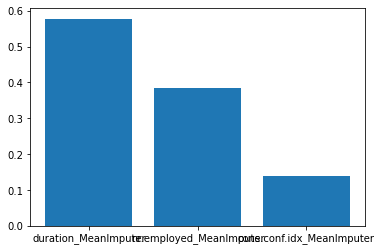

In [15]:
from azureml.interpret import ExplanationClient

client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)

feature_importance_dict = engineered_explanations.get_feature_importance_dict()

# top 3 metrics
xx, yy = zip(*feature_importance_dict.items())
plt.bar(xx[:3], yy[:3])

## delete compute cluster

In [29]:
cpu_cluster.delete()